In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# cd "C:\Users\Dell\Desktop\Zen\flight_delay_ml_project"


In [9]:
df = pd.read_csv("C:\\Users\\Dell\\Desktop\\Zen\\flight_delay_ml_project\\Flight_delay.csv")


In [10]:
df.head()


,DayOfWeek,Date,DepTime,ArrTime,CRSArrTime,UniqueCarrier,Airline,FlightNum,TailNum,ActualElapsedTime,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,4,03-01-2019,1829,1959,1925,WN,Southwest Airlines Co.,3920,N464WN,90,...,3,10,0,N,0,2,0,0,0,32
1,4,03-01-2019,1937,2037,1940,WN,Southwest Airlines Co.,509,N763SW,240,...,3,7,0,N,0,10,0,0,0,47
2,4,03-01-2019,1644,1845,1725,WN,Southwest Airlines Co.,1333,N334SW,121,...,6,8,0,N,0,8,0,0,0,72
3,4,03-01-2019,1452,1640,1625,WN,Southwest Airlines Co.,675,N286WN,228,...,7,8,0,N,0,3,0,0,0,12
4,4,03-01-2019,1323,1526,1510,WN,Southwest Airlines Co.,4,N674AA,123,...,4,9,0,N,0,0,0,0,0,16


In [11]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df


,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


In [12]:
df.isnull().sum()

DayOfWeek       0
Date            0
DepTime         0
Airline         0
Origin          0
Dest            0
CarrierDelay    0
dtype: int64

In [14]:
df['Date'] = pd.to_datetime(df['Date'] , dayfirst=True)
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [15]:
df = df.drop(columns=['Date'])

In [16]:
categories = df.select_dtypes(include=['object']).columns
categories


Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [17]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [18]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)

In [19]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
train_set = pd.concat([X_train, y_train], axis=1)

In [22]:
train_set['is_delayed_60+'].value_counts()

is_delayed_60+
0    313876
1     25309
Name: count, dtype: int64

In [23]:
train_set['is_delayed_60+'].mean()

np.float64(0.07461709686454294)

In [24]:
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')


In [25]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3) * 100

Airline
Atlantic Southeast Airlines     16.3
Hawaiian Airlines Inc.          14.2
Skywest Airlines Inc.           10.3
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.4
US Airways Inc.                  7.6
United Air Lines Inc.            7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.9
Frontier Airlines Inc.           4.7
Southwest Airlines Co.           3.3
Name: is_delayed_60+, dtype: float64

In [26]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3) * 100
DayOfWeek_pct_delayed


DayOfWeek
1    7.6
2    7.1
3    7.6
4    6.9
5    6.8
6    9.0
7    7.9
Name: is_delayed_60+, dtype: float64

In [27]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3) * 100
pct_delay_by_origin.head(20)


Origin
ACY    40.0
LWB    40.0
MQT    33.8
MCN    27.8
SLE    26.7
SCE    25.0
PFN    23.6
PHF    23.1
MKG    22.6
TRI    22.5
MEI    22.2
HHH    21.8
OAJ    21.5
FAY    21.4
ROW    21.4
VLD    20.3
AVL    19.8
ABI    19.4
EWN    19.3
CMI    18.4
Name: is_delayed_60+, dtype: float64

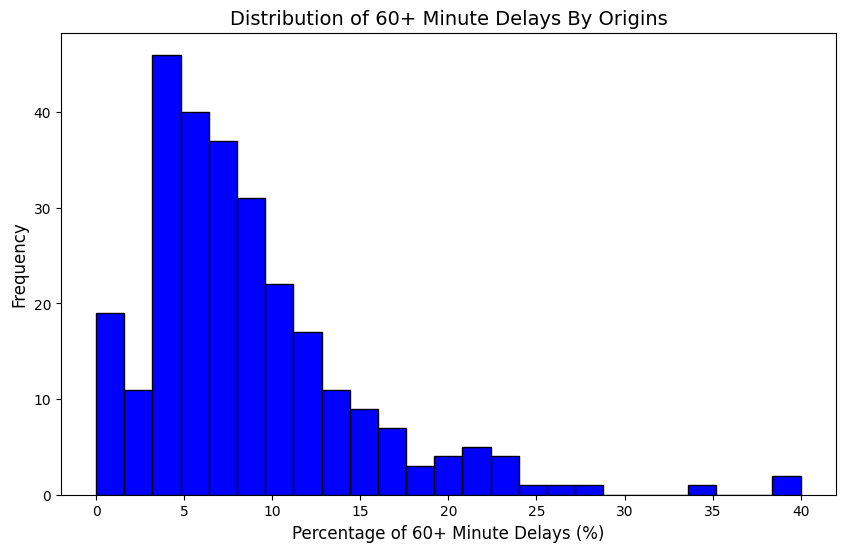

In [28]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()


In [29]:
xgb_model = xgb.XGBClassifier(random_state=0, eval_metric='logloss')

In [31]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [32]:
y_pred = xgb_model.predict(X_test)

In [33]:
print("XGBoost Classifier (Baseline):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


XGBoost Classifier (Baseline):
Accuracy: 0.9246


In [34]:
cm = confusion_matrix(y_test, y_pred)
cm


array([[134322,     61],
       [ 10897,     86]])

In [35]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")


AUC Score: 0.7095


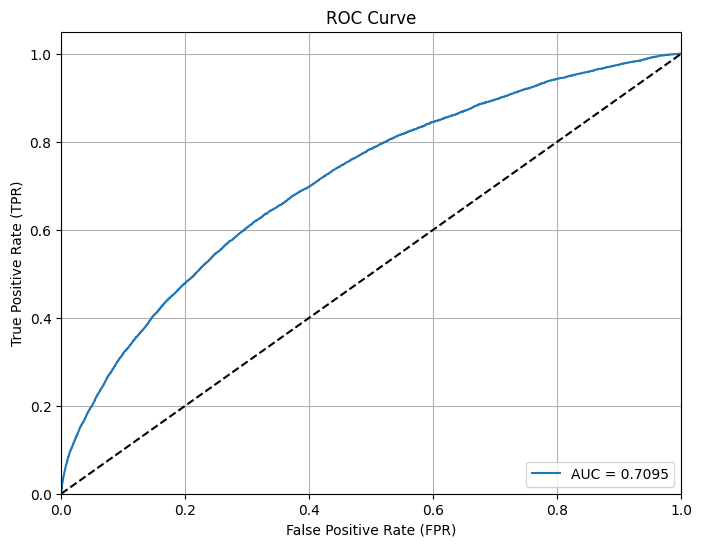

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
